In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


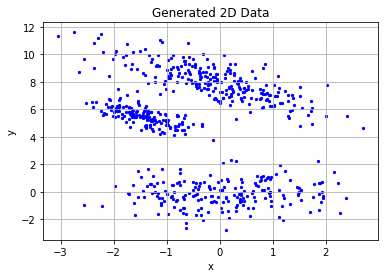

In [39]:
# Generate 2D data similar to the MATLAB code
np.random.seed(0)
z_1 = np.random.randn(2, 200)
z_2_top = np.random.randn(1, 250)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 250))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 150)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 150))))
z = np.hstack((z_1, z_2, z_3))
z = z[:, np.random.permutation(z.shape[1])]
data = z.transpose()

plt.scatter(z[0, :], z[1, :], s=5, c='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated 2D Data')
plt.grid(True)
plt.show()


In [40]:
import torch
import numpy as np
import torch.nn as nn

class eGAUSSpPyTorchV3_fixed(nn.Module):
    def __init__(self, feature_dim, N_max, Gamma_max, kappa_join, S_0):
        super(eGAUSSpPyTorchV3_fixed, self).__init__()

        self.feature_dim = feature_dim
        
        self.N_max = nn.Parameter(torch.tensor(N_max, dtype=torch.float32), requires_grad=True)
        self.Gamma_max = nn.Parameter(torch.tensor(Gamma_max, dtype=torch.float32), requires_grad=True)
        self.kappa_join = nn.Parameter(torch.tensor(kappa_join, dtype=torch.float32), requires_grad=True)
        self.S_0 = nn.Parameter(torch.tensor(S_0, dtype=torch.float32), requires_grad=True)

        self.c = 1
        self.n = [1]
        self.mu = [nn.Parameter(torch.zeros(feature_dim), requires_grad=True)]
        self.S = [nn.Parameter(torch.eye(feature_dim), requires_grad=True)]

        self.V_factor = (2 * np.pi ** (feature_dim / 2) / (feature_dim * torch.exp(torch.lgamma(torch.tensor(float(feature_dim) / 2)))))
                    
    def compute_distance_and_activation(self, z):
        Gamma = torch.zeros(self.c)
        d2 = torch.zeros(self.c)
        for i in range(self.c):
            if self.n[i] < self.N_max:
                d2[i] = torch.norm(z - self.mu[i]) ** 2
            else:
                d2[i] = (z - self.mu[i]).T @ torch.pinverse(self.S[i] / self.n[i]) @ (z - self.mu[i])
            Gamma[i] = torch.exp(-d2[i])
        return Gamma, d2

    def increment_or_add_cluster(self, z, Gamma):
        _, j = torch.max(Gamma, 0)
        if Gamma[j] > self.Gamma_max:
            e = z - self.mu[j]
            updated_mu = self.mu[j] + 1 / (1 + self.n[j]) * e
            updated_S = self.S[j] + e.view(-1, 1) @ (z - self.mu[j]).view(1, -1)
            updated_n = self.n[j] + 1
            
            # Assign the new values
            self.mu[j] = updated_mu
            self.S[j] = updated_S
            self.n[j] = updated_n
        else:
            self.c += 1
            self.n.append(1)
            self.mu.append(nn.Parameter(z.clone(), requires_grad=True))
            self.S.append(nn.Parameter(self.S_0 * torch.eye(self.feature_dim), requires_grad=True))
            Gamma = torch.cat((Gamma, torch.tensor([1.0])))
        return Gamma

    def merge_clusters(self, Gamma):
        merge = True
        max_iterations = 100
        iteration = 0
        
        while merge and iteration < max_iterations:
            V = torch.full((self.c, self.c), float('nan'))
            Sigma_ij = torch.zeros(self.feature_dim, self.feature_dim, self.c, self.c)
            mu_ij = torch.zeros(self.feature_dim, self.c, self.c)
            n_ij = torch.zeros(self.c, self.c)
            for i in range(self.c):
                if Gamma[i] > self.Gamma_max / 4:
                    # Using torch.linalg.eig
                    V[i, i] = self.V_factor * torch.prod(torch.linalg.eig(self.S[i] / self.n[i]).eigenvalues.real)
                    for j in range(i + 1, self.c):
                        if Gamma[j] > self.Gamma_max / 4:
                            n_ij[i, j] = self.n[i] + self.n[j]
                            mu_ij[:, i, j] = (self.n[i] * self.mu[i] + self.n[j] * self.mu[j]) / n_ij[i, j]
                            ZiTZi = (self.n[i] - 1) * (1 / self.n[i]) * self.S[i] + torch.diag(self.mu[i]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(self.mu[i])
                            ZjTZj = (self.n[j] - 1) * (1 / self.n[j]) * self.S[j] + torch.diag(self.mu[j]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(self.mu[j])
                            Sigma_ij[:, :, i, j] = (1 / (n_ij[i, j] - 1)) * (ZiTZi + ZjTZj - torch.diag(mu_ij[:, i, j]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(mu_ij[:, i, j]))
                            # Using torch.linalg.eig
                            V[i, j] = self.V_factor * torch.prod(torch.linalg.eig(Sigma_ij[:, :, i, j]).eigenvalues.real)
                            if V[i, j] < 0:
                                V[i, j] = float('nan')

            kappa = torch.full((self.c, self.c), float('inf'))
            for i in range(self.c):
                for j in range(i + 1, self.c):
                    kappa[i, j] = V[i, j] / (V[i, i] + V[j, j])

            kappa_min = torch.min(kappa[kappa == kappa])
            i, j = (kappa == kappa_min).nonzero(as_tuple=True)

            if kappa_min < self.kappa_join:
                self.mu[i] = nn.Parameter((self.n[i] * self.mu[i] + self.n[j] * self.mu[j]) / (self.n[i] + self.n[j]), requires_grad=True)
                self.S[i] = nn.Parameter(self.S[i] + self.S[j], requires_grad=True)
                self.n[i] += self.n[j]

                del self.n[j]
                del self.mu[j]
                del self.S[j]

                self.c -= 1
                merge = True
            else:
                merge = False
            
            iteration += 1

    def forward(self, z):
        Gamma, d2 = self.compute_distance_and_activation(z)
        Gamma = self.increment_or_add_cluster(z, Gamma)
        self.merge_clusters(Gamma)
        return torch.stack(self.mu)


In [41]:
# Step 1: Instantiate an instance of the class

feature_dim = 2  # For 2D data
N_max = 4       # Max samples per cluster
Gamma_max = 0.01  # Activation threshold
kappa_join = 10  # Threshold for merging clusters
S_0 = 0.01        # Initial covariance


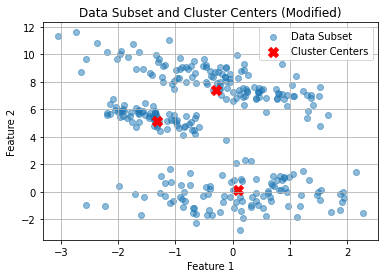

In [42]:
# Use a subset of the data for quicker testing
subset_data = data[:300]

# Reset and test the model with the modified function on the subset
model_fixed = eGAUSSpPyTorchV3_fixed(feature_dim, N_max, Gamma_max, kappa_join, S_0)

for point in subset_data:
    model_fixed(torch.tensor(point, dtype=torch.float32))

cluster_centers_fixed_subset = [mu.detach().numpy() for mu in model_fixed.mu]

plt.scatter(subset_data[:, 0], subset_data[:, 1], label='Data Subset', alpha=0.5)
plt.scatter(*zip(*cluster_centers_fixed_subset), color='red', label='Cluster Centers', s=100, marker='X')
plt.title("Data Subset and Cluster Centers (Modified)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


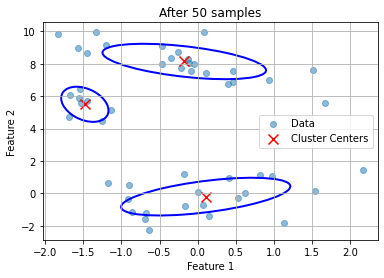

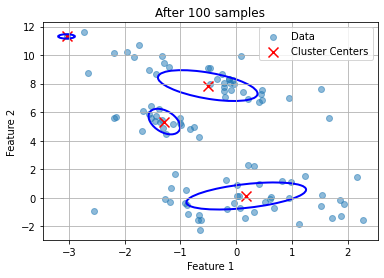

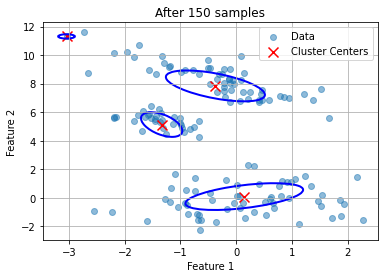

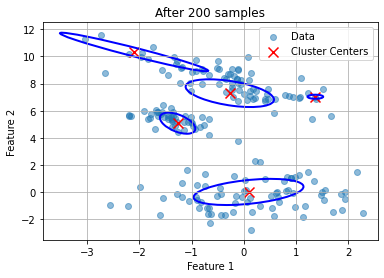

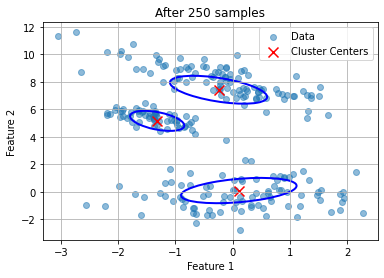

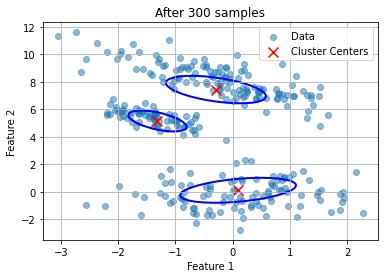

In [43]:
from matplotlib.patches import Ellipse

def plot_clusters(data, model, title):
    """Function to plot data points and cluster ellipsoids."""
    cluster_centers = [mu.detach().numpy() for mu in model.mu]
    
    fig, ax = plt.subplots()
    ax.scatter(data[:, 0], data[:, 1], label='Data', alpha=0.5)
    ax.scatter(*zip(*cluster_centers), color='red', label='Cluster Centers', s=100, marker='x')
    
    # For each cluster, plot the associated ellipsoid using its mean and covariance matrix
    for i in range(model.c):
        mu = model.mu[i].detach().numpy()
        cov_matrix = (model.S[i] / model.n[i]).detach().numpy()
        
        # Compute the eigenvalues and eigenvectors
        vals, vecs = np.linalg.eigh(cov_matrix)
        
        # Compute the angle of the major axis
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        
        # Plot the ellipse with width and height as sqrt of eigenvalues (for visualization purpose, scaling it by a factor)
        factor = 3
        width, height = factor * np.sqrt(vals)
        ell = Ellipse(mu, width, height, angle, edgecolor='blue', lw=2, facecolor='none')
        ax.add_patch(ell)

    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend()
    ax.grid(True)
    plt.show()

# Visualize the ellipsoids for each cluster as data is fed into the model
model_fixed = eGAUSSpPyTorchV3_fixed(feature_dim, N_max, Gamma_max, kappa_join, S_0)

# Process data and plot after every 50 samples
for idx, point in enumerate(subset_data, start=1):
    model_fixed(torch.tensor(point, dtype=torch.float32))
    if idx % 50 == 0:
        plot_clusters(subset_data[:idx], model_fixed, f"After {idx} samples")


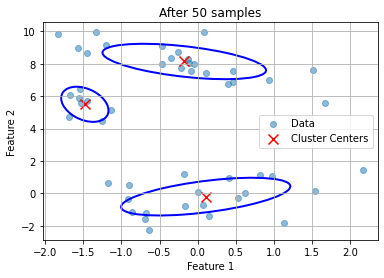

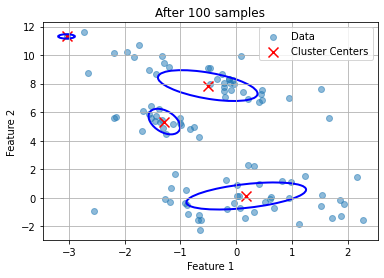

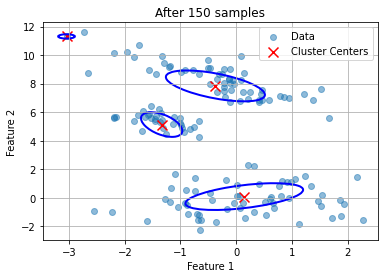

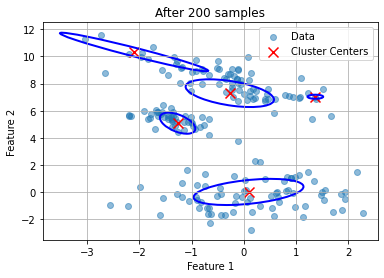

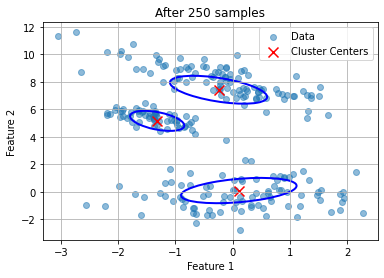

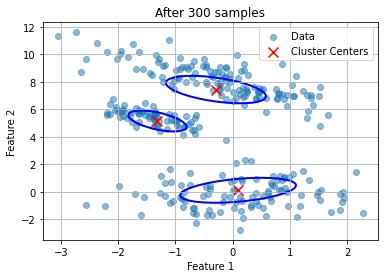

In [44]:
# Test the updated model with the modified function
model_test = eGAUSSpPyTorchV3_fixed(feature_dim, N_max, Gamma_max, kappa_join, S_0)

# Process data and plot after every 50 samples
for idx, point in enumerate(subset_data, start=1):
    model_test(torch.tensor(point, dtype=torch.float32))
    if idx % 50 == 0:
        plot_clusters(subset_data[:idx], model_test, f"After {idx} samples")

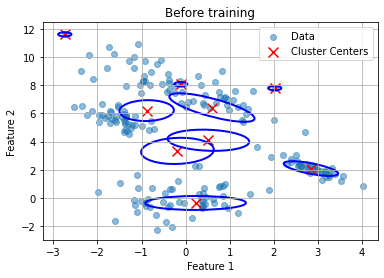

In [49]:
class eGAUSSp(nn.Module):
    def __init__(self, feature_dim, N_max, Gamma_max, kappa_join, S_0):
        super(eGAUSSp, self).__init__()

        self.feature_dim = feature_dim
        self.N_max = nn.Parameter(torch.tensor(N_max, dtype=torch.float32), requires_grad=True)
        self.Gamma_max = nn.Parameter(torch.tensor(Gamma_max, dtype=torch.float32), requires_grad=True)
        self.kappa_join = nn.Parameter(torch.tensor(kappa_join, dtype=torch.float32), requires_grad=True)
        self.S_0 = nn.Parameter(torch.tensor(S_0, dtype=torch.float32), requires_grad=True)

        self.c = 1
        self.n = [1]
        self.mu = nn.ParameterList([nn.Parameter(torch.zeros(feature_dim), requires_grad=True)])
        self.S = nn.ParameterList([nn.Parameter(torch.eye(feature_dim), requires_grad=True)])

        self.V_factor = (2 * np.pi ** (feature_dim / 2) / (feature_dim * torch.exp(torch.lgamma(torch.tensor(float(feature_dim) / 2)))))
    
        # Set default behavior
        self.enable_adding = True
        self.enable_merging = True
        
    def compute_distance_and_activation(self, z):
        Gamma = torch.zeros(self.c)
        d2 = torch.zeros(self.c)
        for i in range(self.c):
            if self.n[i] < self.N_max:
                d2[i] = torch.norm(z - self.mu[i]) ** 2
            else:
                d2[i] = (z - self.mu[i]).T @ torch.pinverse(self.S[i] / self.n[i]) @ (z - self.mu[i])
            Gamma[i] = torch.exp(-d2[i])
        return Gamma, d2

    def increment_or_add_cluster(self, z, Gamma):
        _, j = torch.max(Gamma, 0)
        
        # If adding is enabled and the condition is met
        if self.enable_adding and Gamma[j] <= self.Gamma_max:
            self.c += 1
            self.n.append(1)
            self.mu.append(nn.Parameter(z.clone(), requires_grad=True))
            self.S.append(nn.Parameter(self.S_0 * torch.eye(self.feature_dim), requires_grad=True))
            Gamma = torch.cat((Gamma, torch.tensor([1.0])))
        else:  # Otherwise just increment the existing cluster
            e = z - self.mu[j]
            updated_mu = self.mu[j] + 1 / (1 + self.n[j]) * e
            updated_S = self.S[j] + e.view(-1, 1) @ (z - self.mu[j]).view(1, -1)
            updated_n = self.n[j] + 1
            
            # Assign the new values
            self.mu[j].data = updated_mu
            self.S[j].data = updated_S
            self.n[j] = updated_n
        return Gamma


    def merge_clusters(self, Gamma):
        
        if not self.enable_merging:
            return
        
        merge = True
        max_iterations = 10
        iteration = 0
        
        while merge and iteration < max_iterations:
            V = torch.full((self.c, self.c), float('nan'))
            Sigma_ij = torch.zeros(self.feature_dim, self.feature_dim, self.c, self.c)
            mu_ij = torch.zeros(self.feature_dim, self.c, self.c)
            n_ij = torch.zeros(self.c, self.c)
            for i in range(self.c):
                if Gamma[i] > self.Gamma_max / 4:
                    # Using torch.linalg.eig
                    V[i, i] = self.V_factor * torch.prod(torch.linalg.eig(self.S[i] / self.n[i]).eigenvalues.real)
                    for j in range(i + 1, self.c):
                        if Gamma[j] > self.Gamma_max / 4:
                            n_ij[i, j] = self.n[i] + self.n[j]
                            mu_ij[:, i, j] = (self.n[i] * self.mu[i] + self.n[j] * self.mu[j]) / n_ij[i, j]
                            ZiTZi = (self.n[i] - 1) * (1 / self.n[i]) * self.S[i] + torch.diag(self.mu[i]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(self.mu[i])
                            ZjTZj = (self.n[j] - 1) * (1 / self.n[j]) * self.S[j] + torch.diag(self.mu[j]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(self.mu[j])
                            Sigma_ij[:, :, i, j] = (1 / (n_ij[i, j] - 1)) * (ZiTZi + ZjTZj - torch.diag(mu_ij[:, i, j]) @ torch.ones(self.feature_dim, self.feature_dim) @ torch.diag(mu_ij[:, i, j]))
                            # Using torch.linalg.eig
                            V[i, j] = self.V_factor * torch.prod(torch.linalg.eig(Sigma_ij[:, :, i, j]).eigenvalues.real)
                            if V[i, j] < 0:
                                V[i, j] = float('nan')

            kappa = torch.full((self.c, self.c), float('inf'))
            for i in range(self.c):
                for j in range(i + 1, self.c):
                    kappa[i, j] = V[i, j] / (V[i, i] + V[j, j])
                    
            kappa_min = torch.min(kappa[kappa == kappa])
            i, j = (kappa == kappa_min).nonzero(as_tuple=True)

            if kappa_min  < self.kappa_join:
                self.mu[i].data = (self.n[i] * self.mu[i] + self.n[j] * self.mu[j]) / (self.n[i] + self.n[j])
                self.S[i].data = self.S[i] + self.S[j]
                self.n[i] += self.n[j]

                del self.n[j]
                self.mu = nn.ParameterList([self.mu[k] for k in range(len(self.mu)) if k != j])
                self.S = nn.ParameterList([self.S[k] for k in range(len(self.S)) if k != j])

                self.c -= 1
                merge = True
            else:
                merge = False
            
            iteration += 1

    def toggle_adding(self, enable=None):
        """Toggle the adding mechanism. If enable is not provided, it will just switch the current state."""
        self.enable_adding = not self.enable_adding if enable is None else enable

    def toggle_merging(self, enable=None):
        """Toggle the merging mechanism. If enable is not provided, it will just switch the current state."""
        self.enable_merging = not self.enable_merging if enable is None else enable
    
    
    def forward(self, z):
        Gamma, d2 = self.compute_distance_and_activation(z)
        Gamma = self.increment_or_add_cluster(z, Gamma)
        self.merge_clusters(Gamma)
        return torch.stack([mu for mu in self.mu])
    
# Test the modified model
subset_data = data[:200]

# Test the modified model using the correct class instance
model= eGAUSSp(feature_dim, N_max, Gamma_max, kappa_join, S_0)

for point in subset_data:
    model(torch.tensor(point, dtype=torch.float32))

cluster_centers_fixed_subset_v2 = [mu.detach().numpy() for mu in model.mu]

# Plot the results
plot_clusters(subset_data, model, f"Before training")

In [50]:
# Generate 2D data similar to the MATLAB code
np.random.seed(0)
z_1 = np.random.randn(2, 200)
z_2_top = np.random.randn(1, 250)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 250))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 150)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 150))))
z_4_top = 3 + 0.5 * np.random.randn(1, 150)
z_4 = np.vstack((z_4_top, -z_4_top + (5 + 0.2 * np.random.randn(1, 150))))
z = np.hstack((z_1, z_2, z_3, z_4))
z = z[:, np.random.permutation(z.shape[1])]
data = z.transpose()

Epoch [1/10], Loss: 1.0288


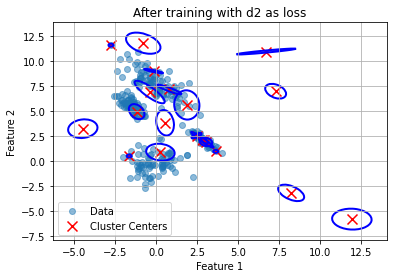

Epoch [2/10], Loss: 1.3438


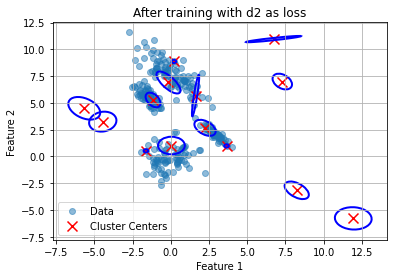

Epoch [3/10], Loss: 1.4738


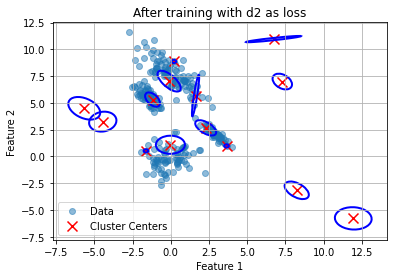

Epoch [4/10], Loss: 1.4686


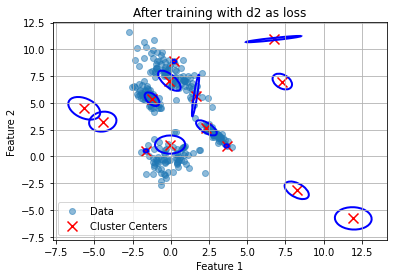

Epoch [5/10], Loss: 1.4937


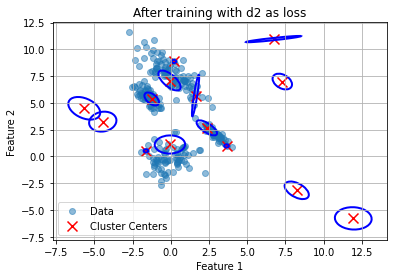

Epoch [6/10], Loss: 1.4746


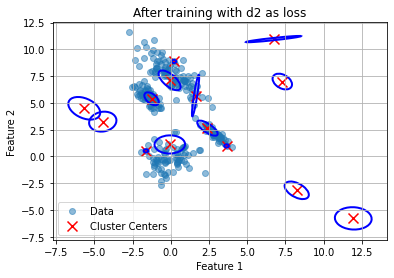

Epoch [7/10], Loss: 1.4575


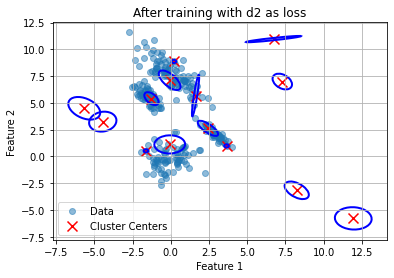

KeyboardInterrupt: 

In [52]:
# Training loop for the updated model
learning_rate = 0.001
num_epochs = 10

# Test the modified model
subset_data = data[0:300]

# Initialize model and optimizer
optimizer_updated = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.toggle_adding(True)
model.toggle_merging(True)

# Training loop using d2 as the loss
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for point in subset_data:
        # Forward pass to get the cluster centers
        cluster_centers = model(torch.tensor(point, dtype=torch.float32))
        
        # Compute Gamma and d2 values
        psi, d2 = model.compute_distance_and_activation(torch.tensor(point, dtype=torch.float32))
        
       # Compute the FCM loss
        loss = torch.min(d2)

        # Backpropagation
        optimizer_updated.zero_grad()
        loss.backward()
        optimizer_updated.step()
        
        epoch_loss += loss.item()

    # Print epoch loss
    avg_loss = epoch_loss / len(subset_data)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plot the results after training using d2 as the loss
    plot_clusters(subset_data, model, f"After training with d2 as loss")

S_0_value = model.S_0.item()
N_max_value = model.N_max.item()
kappa_join_value = model.kappa_join.item()

S_0_value, N_max_value, kappa_join_value